# ok (scrapped in 2 minutes saturday 15/sep/2018)

# step 1 : scraping

In [1]:
# import libraries
import pickle
import requests
from bs4 import BeautifulSoup
import os
from googletrans import Translator
import string
import pandas as pd
import collections
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
from sklearn.cluster import KMeans, MiniBatchKMeans
import logging
from optparse import OptionParser
import sys
import numpy as np
import enchant
from nltk.metrics import edit_distance
import matplotlib.pyplot as plt

/home/datascince/miniconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:

#!/usr/bin/python3
try:
    os.remove('scraped_data[PEMRA_complaints].csv')
except OSError:
    pass


url = 'http://58.65.182.183/complaints/'
r = requests.get(url)
if r.status_code == 200:
    html = r.text
    months = []
    soup = BeautifulSoup(html, 'lxml')
    a = soup.select('ul > li')
    for i in a[1:]:
        months.append(i.text)
c = 1
cc = 'b'
        
lst = []
for m in months:
    month = m.split()[0]
    year = m.split()[1]
    r = requests.get('http://58.65.182.183/complaints/index1.php?m={}&yy={}'.format(month, year))
    if r.status_code == 200:
        html = r.text
        soup = BeautifulSoup(html, 'lxml')
        tv_channels = soup.select('.tablesorter > tbody > tr')
        for i in tv_channels:
            a = i.text.strip().split('\n')
#                 url = 'http://58.65.182.183/complaints/channelwise1.php?ch={}&t=5&m=January&yy=2017'.format(a[1])
            url2 = 'http://58.65.182.183/complaints/scripts/server_processing.php?m={}&yy={}&ch={}&sEcho=1&iColumns=2&sColumns=&iDisplayStart=0&iDisplayLength=500&mDataProp_0=0&mDataProp_1=1&sSearch=&bRegex=false&sSearch_0=&bRegex_0=false&bSearchable_0=true&sSearch_1=&bRegex_1=false&bSearchable_1=true&iSortCol_0=0&sSortDir_0=asc&iSortingCols=1&bSortable_0=true&bSortable_1=true&_=1536844703456'.format(month, year, a[1])
            r = requests.get(url2)
            html = r.text
            if html:
                complaints = r.json()['aaData']
                a.append(month)
                a.append(year)
                a.append(complaints)
#                 a.append(url2)
                lst.append(a)
with open('all_pickle_automatic.pkl', 'wb') as f:
        pickle.dump(lst, f)

with open(+'.pkl', 'rb') as f:
    mynewlist = pickle.load(f)

# step 2: load list and creat a csv file

In [ ]:
file_name = 'scraped_data[PEMRA_complaints].csv'
try:
    os.remove(file_name)
except OSError:
    pass
with open('all_pickle_automatic.pkl', 'rb') as f:
    lst = pickle.load(f)
    
with open(file_name,'a+', encoding='utf-8') as file:
    file.write('Serial#|Channel name|Complaints Received Qty.|Month|Year|Complaint ID|Complaint\n')
    for c in lst:
        for i in range(int(c[2])):
            first_5 = '|'.join(c[:5])
            sixth = c[5][i][0]
            last = c[5][i][1].replace('"', '').replace("'", '').replace('|', '')
#             last = last.
            one_complaint = first_5 + '|' + sixth + '|' + last.replace('\n', ' ').replace('\r', ' ').replace('😊', '')
            file.write(one_complaint)
            file.write('\n')
os.system('libreoffice {}'.format(file_name))

# step 3: Leave comments written in non-English

In [ ]:
translator = Translator(service_urls=['translate.google.com','translate.google.co.kr',])

a = []
b = []
ab = []
# remove punctuations
df = pd.read_csv('scraped_data[PEMRA_complaints].csv', delimiter= '|')
for i in df.Complaint:
    printable = set(string.printable)
    ab.append("".join(list(filter(lambda x: x in printable, i))))
df.Complaint = ab

# keep only english complaints
column_to_check = df['Complaint']
for i in range(len(column_to_check)):
    if translator.detect(column_to_check[i]).lang != 'en':
        a.append(column_to_check[i])
        b.append(i)

# save non_English complaints indexes in drive

In [ ]:
indexes = b
taxes = a
new_df = df.drop(indexes)
new_df.to_csv('only_english.csv', header=True,  sep='|', index=False)

with open('non_english_indexs.pkl', 'wb') as f:
        pickle.dump(indexes, f)
with open('non_english_complaints.pkl', 'wb') as f:
        pickle.dump(taxes, f)

In [ ]:
os.system('spd-say "your program has finished"')

# NLP (unsupervised learning)(neg, pos)

In [ ]:
paragraph = "It was one of the worst movies I've seen, despite good reviews. \
... Unbelievably bad acting!! Poor direction. VERY poor production. \
... The movie was bad. Very bad movie. VERY bad movie. VERY BAD movie. VERY BAD movie!"
lines_list = tokenize.sent_tokenize(paragraph)
sid = SentimentIntensityAnalyzer()
compound = []
neg = []
neu = []
pos = []
df = pd.read_csv('only_english.csv', delimiter='|')
sentences = df.Complaint
for sentence in sentences:
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        if k == 'neg':               neg.append(ss[k])
#         elif k == 'compound':            compound.append(ss[k])
#         elif k == 'neu':               neu.append(ss[k])
        elif k == 'pos':               pos.append(ss[k])
# df['compound'] = compound
df['neg'] = neg
# df['neu'] = neu
df['pos'] = pos
df.to_csv('nlp.csv', header=True,  sep='|', index=False)
os.system('libreoffice nlp.csv')

In [ ]:
df = pd.read_csv('only_english.csv', delimiter='|')

lst = []

# drop no meaningfull complaints (smaller than 3 words)
c = 0
for i in df.Complaint:
    if len(i.split()) < 3:
        lst.append(c)
    c += 1

#remove spaces from star and end
remove_spaces = []
for i in df.Complaint:
    remove_spaces.append(i.strip())
df.Complaint = remove_spaces

# remove empy strings
c = 0
for i in df.Complaint:
    if not i.strip():
        lst.append(c)
    c += 1

#remove camplaints contain only link nothing else
c = 0
for i in df.Complaint:
    if len(i.split()) < 3 and i[:5] == 'https':
        lst.append(c)
    c += 1

# remove all (' ')
c = 0
for i in df.Complaint:
    if i == '. .':
        lst.append(c)
    c += 1

# convert all words to lower case, and remove spaces otherthan one between any two words.
lower = []
for i in df.Complaint:
    a = ''.join([z.lower() for z in i])
    lower.append(' '.join([i for i in a.split()]))
df.Complaint = lower

c = 0
for i in df.Complaint:
    if i == '.' or i == '..' or i == '...' or i == '....' or i == '.....':
        lst.append(c)
    c += 1
c = 0
for x in df.Complaint:
    if np.sum([i.isalpha() for i in x.split()]) < 2:
        lst.append(c)
    c += 1


df = df.drop(lst)

df.to_csv('nlp_cleaned.csv', header=True,  sep='|', index=False)
os.system('libreoffice nlp_cleaned.csv')

In [ ]:
# https://nlpforhackers.io/recipe-text-clustering/
df = pd.read_csv('nlp_cleaned.csv', delimiter = '|')
 
def process_text(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens
 
 
def cluster_texts(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(tokenizer=process_text,
                                 stop_words=stopwords.words('english'),
                                 max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
 
    tfidf_model = vectorizer.fit_transform(texts)
    km_model = KMeans(n_clusters=clusters)
    km_model.fit(tfidf_model)
 
    clustering = collections.defaultdict(list)
 
    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)
 
    return clustering
 

try:
    num_clusters = int(input('How many clusturs you need? \n(by default 5)'))
except:
    num_clusters = 5
articles = list(df.Complaint)
clusters = cluster_texts(articles, num_clusters)
    
lst = []
for i in range(len(df)):
    for b in clusters:
        if i in clusters[b]:
            lst.append((i, b))
            
cluster_number = [lst[i][1] for i in range(len(lst))]
df['Clusters'] = cluster_number

df.to_csv('nlp_clusters_1.csv', header=True,  sep='|', index=False)
# os.system('libreoffice nlp_clusters_1.csv')

### Punctuation remove karny k lye R use ki h, is marhaly par  <removePunctuation.R> run karen to 1 new csv ban jay gi,, aagy ham us csv <MyData.csv> ko use karen gy

# correct Spelling

In [ ]:
class SpellingReplacer(object):
    def __init__(self, dict_name = 'en_GB', max_dist = 2):
        self.spell_dict = enchant.Dict(dict_name)
        self.max_dist = 2

    def replace(self, word):
        if self.spell_dict.check(word):
            return word
        suggestions = self.spell_dict.suggest(word)

        if suggestions and edit_distance(word, suggestions[0]) <= self.max_dist:
            return suggestions[0]
        else:
            return word
def spell_check(word_list):
    checked_list = []
    for item in word_list:
        replacer = SpellingReplacer()
        r = replacer.replace(item)
        checked_list.append(r)
    return checked_list

df = pd.read_csv('MyData.csv', delimiter = '|')
z = []
for i in df.Complaint:
     z.append(' '.join(spell_check(i.split())))
df.Complaint = z

with open('corrected_sentences_after_puntuation.pkl', 'wb') as f:
        pickle.dump(list(df.Complaint), f)
        
df.to_csv('MyData2.csv', header=True,  sep='|', index=False)
# os.system('libreoffice MyData1.csv')

# Channel qty. by Channels

In [ ]:
df = pd.read_csv('MyData2.csv', delimiter='|')
dic = {}
for i in df['Channel.name'].unique():
    dic[i] = list(df['Channel.name']).count(i)
channel_complaint_qty = pd.DataFrame.from_dict(dic, orient='index')
channel_complaint_qty = channel_complaint_qty.reset_index()
channel_complaint_qty.columns = ['Channel_name', 'qty.']
channel_complaint_qty.sort_values(by = 'qty.', ascending=False, inplace=True)
channel_complaint_qty.to_csv('channel_complaint_qty.csv', header=True,  sep='|', index=True)
os.system('libreoffice channel_complaint_qty.csv')

lemmatizer = []
for i in df.Complaint:
    a = ','.join([wnl.lemmatize(i) for z in i.split()])
    lemmatizer += a


# replacing 

In [180]:
df = pd.read_csv('MyData2.csv', delimiter = '|')
amir = 'amir'
ban = 'ban'
islam = 'Islam'
replacing = []
for i in df.Complaint:
    a = i.replace('aaamir', amir).replace('aamir', amir).replace('dramir', amir).replace('draamir', amir).replace('liyaqat','liaqat').replace('liaqats', 'liaqat').replace('liqat', 'liaqat').replace('laiqat', 'liaqat').replace('layaqat', 'liaqat').replace('liauqat', 'liaqat').replace('lyaqat', 'liaqat').replace('banned', ban).replace('banning', ban).replace('bans', ban).replace('ban', ban).replace('banning', ban).replace('baned', ban).replace('bans', ban).    replace('bannned', ban).replace('Amie', amir).replace('banned', ban).replace('Islamic', islam).replace('channels', 'channel').replace( 'liaquat', 'liaqat')
    b = ' '.join([i for i in a.split() if not i.isnumeric() and i[:4]  != 'http'])
    replacing.append(b)
df.Complaint = replacing
df.to_csv('MyData3.csv', header=True,  sep='|', index=False)
os.system('libreoffice MyData3.csv')

0

# unique words and counts

In [181]:
df = pd.read_csv('MyData3.csv', delimiter = '|')
a = []
for i in df.Complaint:
    a += i.split()

d = {}
for i in set(a):
    d[i] = a.count(i)
unique_words_count = pd.DataFrame.from_dict(d, orient='index')
unique_words_count.to_csv('unique_words_count_dict_3.csv', header=False,  sep='|', index=True)
os.system('libreoffice unique_words_count_dict_3.csv')

0


# Top 10 terms per each cluster

In [62]:
##### logging.basicConfig(level=logging.INFO,format='%(asctime)s %(levelname)s %(message)s')
op = OptionParser()
op.add_option("--lsa",dest="n_components", type="int",help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",action="store_false", dest="minibatch", default=True,help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",action="store_true", dest="use_idf", default=True,help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",action="store_true", default=False,help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",action="store_true", dest="verbose", default=False,help="Print progress reports inside k-means algorithm.")
def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
categories = None
df = pd.read_csv('MyData3.csv', delimiter = '|')
dataset = df
labels = dataset.Clusters
true_k = np.unique(labels).shape[0]

try: 
    max_df = int(input('Enter maximum occurrence(ratio) [press Enter to skip]\n(default: 0.5)\n'))
except: 
    max_df = 0.5

try: 
    n_features = int(input('Enter  maximum features [press Enter to skip]\n(default: 10,000)\n'))
except: 
    n_features = 10000

try: 
    min_df = int(input('Enter minimum occurrence [press Enter to skip]\n(default: 2)\n'))
except: 
    min_df = 2

vectorizer = TfidfVectorizer(max_df=max_df, max_features=n_features,
                             min_df=min_df, stop_words='english',
                             use_idf=opts.use_idf)
X = vectorizer.fit_transform(dataset.Complaint)

km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                     init_size=1000, batch_size=1000, verbose=opts.verbose)
km.fit(X)
total_values = []
if not opts.use_hashing:
#     print("Top 10 terms per each cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    word_dict = {}
    for i in range(true_k):
        print('Cluster {}: '.format(i) ,','.join([terms[ind] for ind in order_centroids[i, :10]]))
        total_values += ','.join([terms[ind] for ind in order_centroids[i, :10]]).split(',')
        word_dict[i] = ','.join([terms[ind] for ind in order_centroids[i, :10]])
word_list = []
for i in df.Clusters:
    word_list.append(word_dict[i])

df['word list'] = word_list
print(len(set(word_dict.values())))
month_year = []
for i,z in zip(list(df['Month']), list(df['Year'])):
    month_year.append(i + ' ' + str(z))
df['Month and Year'] = month_year
df.to_csv('nlp_clusters_3.csv', header=True,  sep='|', index=False)
# os.system('libreoffice nlp_clusters_3.csv')

Enter maximum occurrence(ratio) [press Enter to skip]
(default: 0.5)

Enter  maximum features [press Enter to skip]
(default: 10,000)

Enter minimum occurrence [press Enter to skip]
(default: 2)

Cluster 0:  sahib,lode,morning,dance,shows,vulgarity,tv,ka,girls,vulgar
Cluster 1:  geo,cancel,najam,hi,blasphemer,set,license,khanzada,legal,army
Cluster 2:  sindhi,karachi,terms,province,use,urdu,channel,society,news,words
Cluster 3:  amir,liaqat,biol,dr,program,hate,hussein,tv,spreading,religious
Cluster 4:  channel,news,tv,indian,pakistan,action,stop,islam,petra,ad
5


In [63]:
a = []
for i in range(len(word_dict)):
    a += word_dict[i].split(',')
print('repeated values Qty.: ', true_k*10 - len(set(a)))
print()
q = []
for i in set(a):
    if a.count(i) > 1:
        q.append(i)
#         print(i, a.count(i))
for mz in q:
    m = []
    for i in word_dict:
        if mz in word_dict[i]:
            m.append(i)
    print(mz,m)
a = pd.DataFrame()
a['vectorizered_values'] = vectorizer.get_feature_names()
a.to_csv('vectorizered_values_2.csv', header=True, index = False)
# os.system('libreoffice vectorizered_values_2.csv')

repeated values Qty.:  4

news [2, 4]
channel [2, 4]
tv [0, 3, 4]


#

In [64]:
print('total Observations:   ', len(df))
print()
print('unique Complaints:    ', len(df.Complaint.unique()))
print('duplicaates: \t      ', len(df)-len(df.Complaint.unique()))
print()
print('unique Complaints ID: ', len(df['Complaint.ID'].unique()))
print('duplicates: \t      ', len(df)- len(df['Complaint.ID'].unique()))

total Observations:    13405

unique Complaints:     8955
duplicaates: 	       4450

unique Complaints ID:  9459
duplicates: 	       3946


# Basic visualization

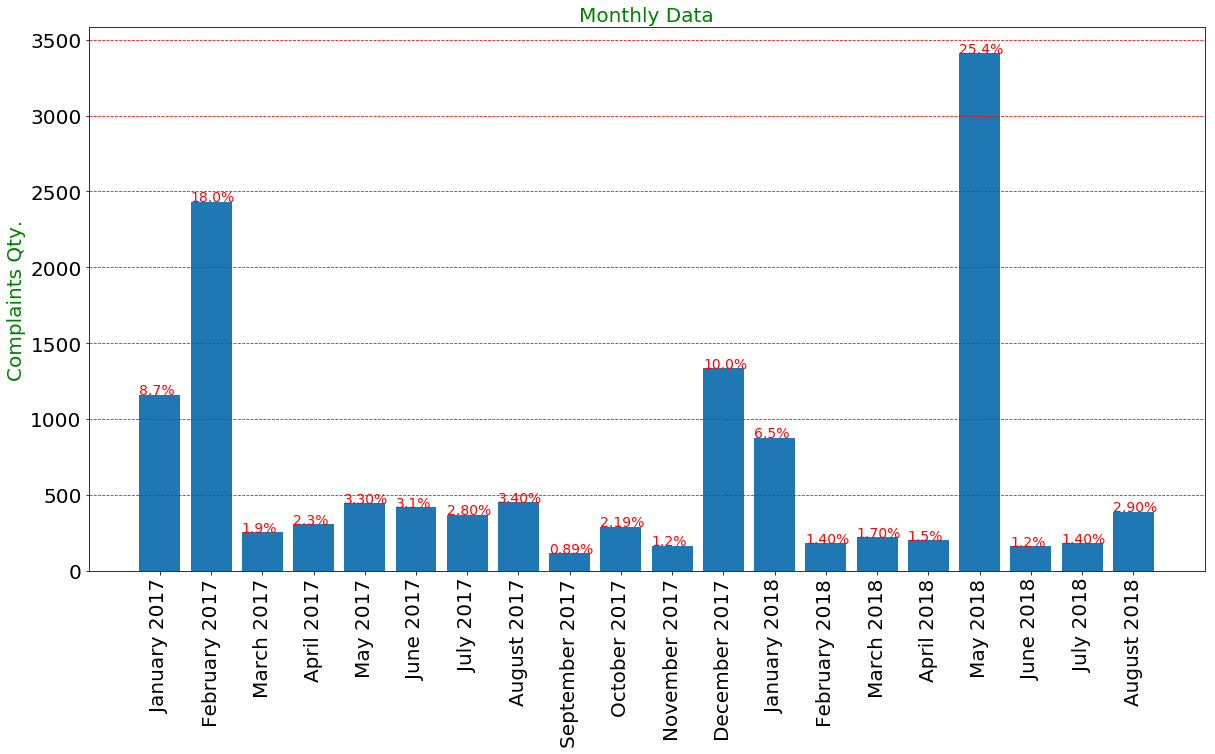

In [117]:
df = pd.read_csv('nlp_clusters_3.csv', delimiter = '|')
month_year = df['Month and Year']
ab = df.groupby(['Month and Year'], sort=False)
plt.figure(figsize=(20,10))
bar = plt.bar(x=[i[0] for i in ab], height = [len(i[1]) for i in ab])
plt.xticks(rotation = 90, size = 20)
plt.title('Monthly Data', size = 20, color = 'g')
plt.ylabel('Complaints Qty.', size = 20, color = 'g')
plt.yticks(size = 20)
plt.grid(axis='y', color='r', linestyle='--')
total = len(df)
for rect in bar: 
    plt.text(rect.get_x(), rect.get_height(),str(round(rect.get_height()/total,3)*100)[:4]+'%', size = 14, color = 'r')
plt.show()

# wo Channels jin ki total complaints 100 sy zyada hen

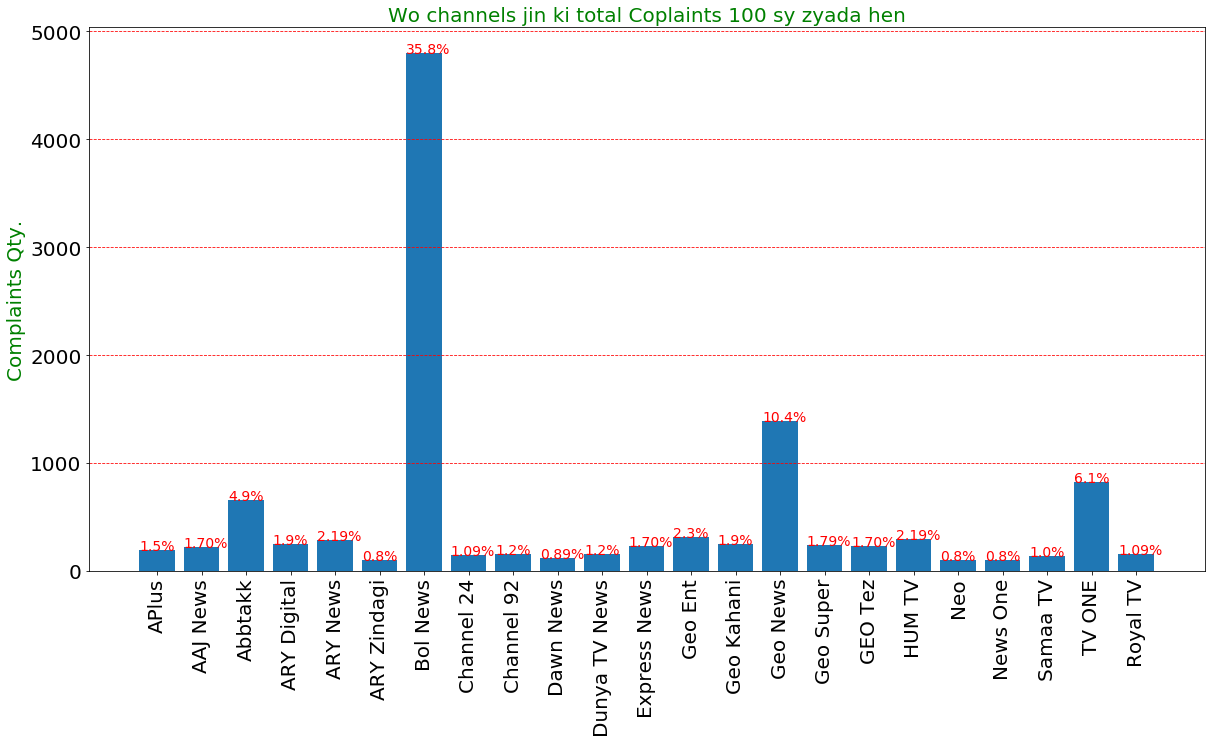

In [67]:
ab = df.groupby(['Channel.name'],sort=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
bar = plt.bar(x=[i[0] for i in ab if len(i[1]) > 100], height = [len(i[1]) for i in ab if len(i[1]) > 100])
plt.xticks(rotation = 90, size = 20)
plt.title('Wo channels jin ki total Coplaints 100 sy zyada hen', size = 20, color = 'g')
plt.ylabel('Complaints Qty.', size = 20, color = 'g')
plt.yticks(size = 20)
plt.grid(axis='y', color='r', linestyle='--')
total = len(df)
for rect in bar: 
    plt.text(rect.get_x(), rect.get_height(),str(round(rect.get_height()/total,3)*100)[:4]+'%', size = 14, color = 'r')
plt.show()


# Bol News (monthly)

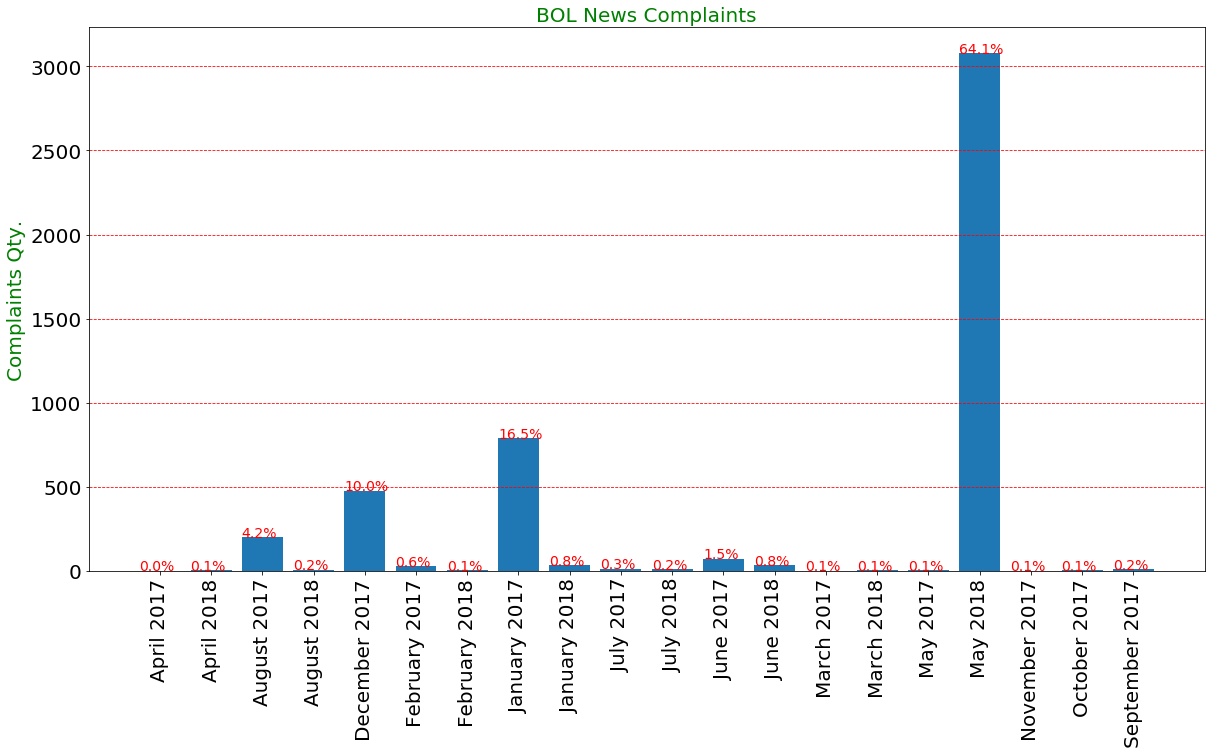

agar May 2018 ki Complaints ko hata kar dekha jay to BOL News ka ratio total Complaints me sy 0.17 h


In [68]:
bol = df[df['Channel.name'] == 'Bol News']
ab = bol.groupby('Month and Year')
plt.figure(figsize=(20,10))
bar = plt.bar(x=[i[0] for i in ab], height = [len(i[1]) for i in ab])
plt.xticks(rotation = 90, size = 20)
plt.title('BOL News Complaints', size = 20, color = 'g')
plt.ylabel('Complaints Qty.', size = 20, color = 'g')
plt.yticks(size = 20)
plt.grid(axis='y', color='r', linestyle='--')
total = len(bol)
for rect in bar: 
    plt.text(rect.get_x(), rect.get_height(),str(round(rect.get_height()/total,3)*100)[:4]+'%', size = 14, color = 'r')
plt.show()
bol_without_may2018 = len(bol[bol['Month and Year'] != 'May 2018'])
bol_in_may2018 = len(bol[bol['Month and Year'] == 'May 2018'])
print('agar May 2018 ki Complaints ko hata kar dekha jay to BOL News ka ratio total Complaints me sy {} h'.format(round(bol_without_may2018/(len(df)-bol_in_may2018), 2)))


In [125]:
print('Complaints for Bol News in May 2018: ')
print(len(df[(df['Channel.name'] == 'Bol News') & (df['Month and Year'] == 'May 2018')]))
print()
print('unique Complaint: ')
print(len(df[(df['Channel.name'] == 'Bol News') & (df['Month and Year'] == 'May 2018')]['Complaint'].unique()))
print()
print('duplicate complaints: ')
print(len(df[(df['Channel.name'] == 'Bol News') & (df['Month and Year'] == 'May 2018')]) - len(df[(df['Channel.name'] == 'Bol News') & (df['Month and Year'] == 'May 2018')]['Complaint'].unique()))

Complaints for Bol News in May 2018: 
3077

unique Complaint: 
3002

duplicate complaints: 
75


In [156]:
d = {}
c = 0
m = 0
total = len(df)
group = list(df.groupby(['word list']))
for i in group:
    word_list = i[0]
    data_frame = i[1]
#     for z in data_frame['Channel.name'].unique():
#         d[z] = len(data_frame[data_frame['Channel.name'] == z])
    d[word_list] = data_frame.sample(5).Complaint
    
Z = 1
for i in d:
    print('_'*100)
    print('group: ', Z)
    print('(' + i + ')')
    Z += 1
    
    print()
    c = 1
    for z in d[i]:
        print('Complain {}: '.format(c), z)
        c += 1
        print()
        

____________________________________________________________________________________________________
group:  1
(amir,liaqat,biol,dr,program,hate,hussein,tv,spreading,religious)

Complain 1:  there is a morning show hosted by sahib lodhihe latterly has no other topic except dancing with girls and celebrate someones wedding with lot of doom dharakabut it is now crossing the limit he invites teen age school college girls and they perform on cheap and valour Indian item songs all the audience including host enjoying their dances and taking full time mazayi mean what is he promoting its not our culture not our values for god sake ban sahib lode and his morning show kindly take action all these type of Indian culture promoting showsplz Pl Pl take a strong action

Complain 2:  they operate some unwanted political show and talk about division of provision and abuse the army so kindly take action as soon as possible we love our country and army

Complain 3:  sahib lode morning show dance of und

In [115]:
may_2018 = df[df['Month and Year'] == 'May 2018']


array(['geo,cancel,najam,hi,blasphemer,set,license,khanzada,legal,army',
       'sahib,lode,morning,dance,shows,vulgarity,tv,ka,girls,vulgar',
       'amir,liaqat,biol,dr,program,hate,hussein,tv,spreading,religious',
       'sindhi,karachi,terms,province,use,urdu,channel,society,news,words',
       'channel,news,tv,indian,pakistan,action,stop,islam,petra,ad'],
      dtype=object)

In [137]:
hundred_top = """"""
group_channels = list(df.groupby('Channel.name'))
for i in group_channels:
    if len(i[1]) < 101:
        group_channels.remove(i)
len(group_channels)


69

In [139]:
sum([len(i[1]) for i in group_channels])

12190